In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from keras.preprocessing.image import img_to_array
from tqdm import tqdm
import math
import PIL

Using TensorFlow backend.


In [3]:
clean_data_path = '/home/evren/classified_data/clean_data/'
noisy_15dB_path = '/home/evren/classified_data/noisy_data/15dB/'


In [4]:
# Data Augmentation

datagen_clean = ImageDataGenerator(
    
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0,  # randomly shift images vertically (fraction of total height)
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,  
    vertical_flip=False, 
    rescale = 1./255,
    preprocessing_function=None,
    data_format='channels_last', # means that the images should have shape (samples, height, width, channels)
    validation_split=0.0,
    dtype='float32'
)

In [5]:
# Data Augmentation

datagen_noisy = ImageDataGenerator(
    
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0,  # randomly shift images vertically (fraction of total height)
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,  
    vertical_flip=False, 
    rescale = 1./255,
    preprocessing_function=None,
    data_format='channels_last', # means that the images should have shape (samples, height, width, channels)
    validation_split=0.2,
    dtype='float32'
)

In [6]:
clean_data_gen = datagen_clean.flow_from_directory(
                clean_data_path,
                target_size=(64,128),
                color_mode='grayscale',
                classes=None,
                class_mode='input', # "input" will be images identical to input images (mainly used to work with autoencoders)
                batch_size=69071,
                shuffle=True, 
                seed=42,
                save_to_dir=None,
                save_prefix='augmented_',
                save_format='png',
                follow_links=False,
                subset=None,
                interpolation='nearest'
)

Found 69071 images belonging to 1 classes.


In [7]:
noisy_15dB_gen = datagen_noisy.flow_from_directory(
                noisy_15dB_path,
                target_size=(64,128),
                color_mode='grayscale',
                classes=None,
                class_mode='input', # "input" will be images identical to input images (mainly used to work with autoencoders)
                batch_size=128,
                shuffle=True, 
                seed=42,
                save_to_dir=None,
                save_prefix='augmented_',
                save_format='png',
                follow_links=False,
                subset=None,
                interpolation='nearest'
)

Found 69071 images belonging to 1 classes.


In [ ]:
print(noisy_15dB_gen.batch_size)
print(clean_data_gen.batch_size)
# steps_per_epoch = 69071 // noisy_15dB_gen.batch_size
# print(steps_per_epoch)

In [8]:
steps_per_epoch = 69071 / noisy_15dB_gen.batch_size

In [ ]:
data_list_15dB = []
batch_index = 1

while batch_index <= steps_per_epoch:
    data = noisy_15dB_gen.next()
    data_list_15dB.append(data[0])
    print(batch_index)    
    batch_index = batch_index + 1

In [ ]:
data_array_15dB = np.asarray(data_list_15dB, dtype=np.float32)

print(len(data_list_15dB))
print(len(data_array_15dB))
del data_list_15dB

In [9]:
height = 64
width = 128
channel = 1


model = Sequential([
    
  # encoder
    Conv2D(8, (3,3), padding="same", activation="relu", input_shape=(height,width,channel)),
    BatchNormalization(),
    MaxPooling2D((2,2),strides=(2,2)),
    
    
    # decoder
    Conv2D(8, (3,3), padding="same", activation="relu"),
    UpSampling2D((2,2)),
    
    Conv2D(channel, (3,3), padding="same", activation="sigmoid") # sigmoid, relu    
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 8)        80        
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 8)        32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 8)         584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 128, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 128, 1)        73        
Total params: 769
Trainable params: 753
Non-trainable params: 16
_________________________________________________________

In [11]:
model.compile(optimizer=Adam(lr=0.0001), loss='mse', metrics=['accuracy'])

In [12]:
history = model.fit(noisy_15dB_gen,
                    epochs=15,
                   )

# If x is a dataset, generator, or keras.utils.Sequence instance, 
# y should not be specified (since targets will be obtained from x). 

  ...
    to  
  ['...']
Train for 540 steps
Epoch 1/15
540/540 [==============================] - 119s 220ms/step - loss: 0.0063 - accuracy: 1.2389e-06
Epoch 2/15
540/540 [==============================] - 119s 221ms/step - loss: 0.0026 - accuracy: 1.5658e-06
Epoch 3/15
540/540 [==============================] - 121s 223ms/step - loss: 0.0020 - accuracy: 1.6648e-06
Epoch 4/15
540/540 [==============================] - 121s 223ms/step - loss: 0.0018 - accuracy: 1.6736e-06
Epoch 5/15
540/540 [==============================] - 120s 223ms/step - loss: 0.0016 - accuracy: 1.6825e-06
Epoch 6/15
540/540 [==============================] - 120s 223ms/step - loss: 0.0015 - accuracy: 1.5977e-06
Epoch 7/15
540/540 [==============================] - 120s 222ms/step - loss: 0.0014 - accuracy: 1.7267e-06
Epoch 8/15
540/540 [==============================] - 119s 220ms/step - loss: 0.0014 - accuracy: 1.6790e-06
Epoch 9/15
540/540 [==============================] - 119s 220ms/step - loss: 0.0013 - accu

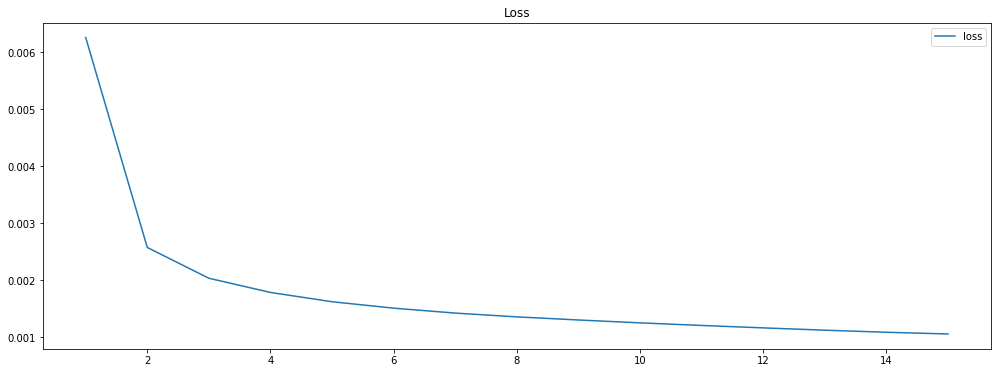

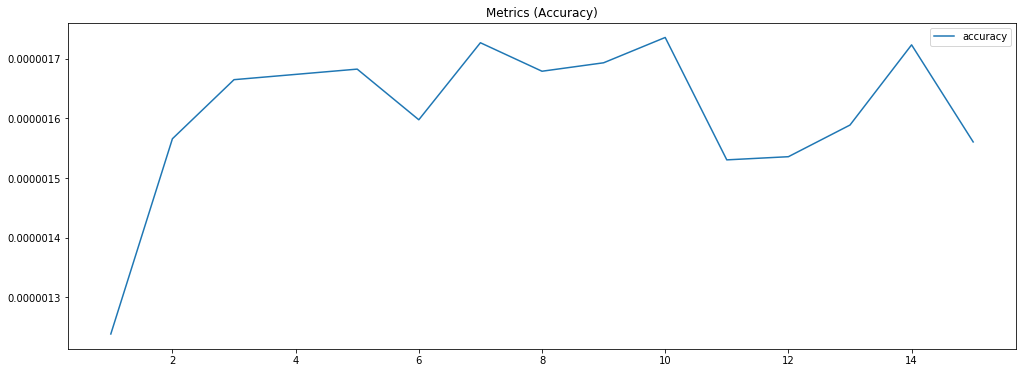

In [15]:
plt.rcParams['figure.figsize'] = (17,6)
fig, ax1 = plt.subplots()
xepochs = range(1,len(history.history['loss']) + 1)

plt.plot(xepochs, history.history['loss'], label = 'loss')
# plt.plot(xepochs, history.history['val_loss'], label = 'val_loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(xepochs, history.history['accuracy'], label = 'accuracy')
# plt.plot(xepochs, history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Metrics (Accuracy)')
plt.legend()
plt.show()

In [16]:
noisy_20dB_path = '/home/evren/classified_data/noisy_data/20dB/'

In [17]:
noisy_20dB_gen = datagen_clean.flow_from_directory(
                noisy_20dB_path,
                target_size=(64,128),
                color_mode='grayscale',
                classes=None,
                class_mode='input', # "input" will be images identical to input images (mainly used to work with autoencoders)
                batch_size=69071,
                shuffle=True, 
                seed=42,
                save_to_dir=None,
                save_prefix='augmented_',
                save_format='png',
                follow_links=False,
                subset=None,
                interpolation='nearest'
)

Found 69071 images belonging to 1 classes.


In [ ]:
# kernel died while predicting

In [ ]:
decoded_20dB = model.predict(noisy_20dB_gen)
decoded_clean = model.predict(clean_data_gen)

In [ ]:
plt.figure(figsize=(17,4))
for i in range(1,7):
    ax = plt.subplot(1,7,i)
    plt.imshow(noisy_20dB_gen[i])
plt.show()

# Displaying prediction_train images
plt.figure(figsize=(17,4))
for i in range(1,7):
    ax = plt.subplot(1,7,i)
    plt.imshow(decoded_20dB[i])
plt.show()

In [ ]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse)) 
    return psnr

In [ ]:
print(f'15dB PSNR mean: {PSNR(noisy_15dB, decoded_15dB)}')

for i in range(len(noisy_15dB)):
    
    value = PSNR(noisy_15dB[i], decoded_15dB[i]) 